In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection  import cross_val_score
import sklearn.metrics 
import xgboost as xgb
import matplotlib.pylab as plt

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class MLPipe:
    # type_c_or_r: c  表示分类模型，r 表示回归模型
    def __init__(self, train_file, test_file, y_col, id_col, ft_name, type_c_or_r):
        self.train_file = train_file
        self.test_file = test_file
        self.y_col = y_col
        self.id_col = id_col
        self.type_c_or_r = type_c_or_r
        self.col_is_train = 'col_is_train'
        self.mod_list = [] 
        self.rand_state = 43
        self.ft_name = ft_name  # 数据集名称 
    
    # 用来标识数据集的名字，主要用来输出结果文件名
    def set_ft_name(self, ft_name):
        self.ft_name = ft_name
        
    # 读取文件，然后合并两个文件
    def parse_file(self):
        self.src_train_df = pd.read_csv(self.train_file)
        self.src_test_df = pd.read_csv(self.test_file)
        
        self.train_df = self.src_train_df.copy()
        self.test_df = self.src_test_df.copy()
        
        # 设置test数据的y值为0，并且区分
        self.test_df[self.y_col] = 0
        self.test_df[self.col_is_train] = 0 
        self.train_df[self.col_is_train] = 1
        # 合并两个数据集，后续所有操作都在all_df中
        self.all_df = pd.concat([self.train_df, self.test_df],ignore_index=True)
        
        self.print_shape()
            
    def print_shape(self):
        print("Train Shape: %d:%d" %(self.train_df.shape))
        print("Test  Shape: %d:%d" %(self.test_df.shape))
        print("All   Shape: %d:%d" %(self.all_df.shape))
        
    def split_X_y(self):
        self.X_train = self.all_df[self.all_df[self.col_is_train] == 1]
        self.y_train = self.X_train[self.y_col]
        self.X_train = self.X_train.drop(self.y_col, axis=1)

        self.X_test = self.all_df[self.all_df[self.col_is_train] == 0]
        self.y_test = self.X_test[self.y_col]
        self.X_test = self.X_test.drop(self.y_col, axis=1)
        
    def out_res_file(self):
        y_pred =  self.mod.predict(self.X_test)
        output = pd.DataFrame({'id': self.X_test[self.id_col].astype(np.int32), self.y_col: y_pred})
        out_file = self.res_file
        print('out_res_file to %s' %out_file)
        output.to_csv(out_file, index=False)

In [5]:
class XGBC_ML(MLPipe):
    #print("MSE:",mean_squared_error(y_eval, y_pred))      
    def gen_model(self):   
        self.model_name = 'XGBC'
        self.params={
            'n_estimators':10,
            'objective': 'binary:logistic', #回归问题 reg:linear 分类问题  binary:logistic  排序 rank:pairwise
            'learning_rate': 0.1, # 学习率，默认0.3
            'max_depth':6, # 构建树的深度，越大越容易过拟合.默认6 
            'subsample':1, # 随机采样训练样本，默认1
            'min_child_weight':1, # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
            #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
            #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
            'seed':819
            }
            #from sklearn.ensemble import XGBRegressor
        self.mod = xgb.XGBClassifier(**self.params)
        self.res_file = 'f%s_m%s_n%d_d%s.csv'  %(self.ft_name, self.model_name, 
                                                 self.mod.n_estimators,
                                                 self.mod.max_depth)
        self.early_stopping_rounds = 50
        print  self.mod 
    
    def choose_best_n_estimators(self):
        xgb_param = self.mod.get_xgb_params()
        xgtrain = xgb.DMatrix(self.X_train, label=self.y_train)
        #max_n_estimators = self.mod.get_params()['n_estimators']
        max_n_estimators = 1000
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=max_n_estimators,
                    nfold=5,metrics='auc', early_stopping_rounds=50, verbose_eval=1,
                    seed =819)
        self.mod.set_params(n_estimators=cvresult.shape[0])
        print 'Set best_n_estimators:%d'%(cvresult.shape[0])
        
        # plot 
        cv_mean = cvresult.iloc[:,[0,2]]
        cv_mean.plot()
        plt.show()
        
    def mod_fit(self, mod, plot_imp=True):
        eval_set=[(self.X_train, self.y_train)]
        # 'eval_metric': 'auc', # rmse mae logloss error auc 
        mod.fit(self.X_train, self.y_train, eval_metric='auc', eval_set=eval_set)
        
        #Predict training set:
        dtrain_predictions = mod.predict(self.X_train)
        dtrain_predprob = mod.predict_proba(self.X_train)[:,1]
            
        #Print model report:
        print "\nModel Report"
        print "Accuracy : %.4g" % metrics.accuracy_score(self.y_train, dtrain_predictions)
        print "AUC Score (Train): %f" % metrics.roc_auc_score(self.y_train, dtrain_predprob)
                        
        feat_imp = pd.Series(mod.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        
    def mod_cv(self, cv=5):
        scores = cross_val_score(self.mod, self.X_train, self.y_train, cv=cv, scoring='r2')
        print("Mod[%s]  R2: %0.6f (+/- %0.6f)") %(self.model_name, scores.mean(), scores.std())

In [8]:
ml = XGBC_ML(train_file='./driver/train.csv', test_file='./driver/test.csv', 
            y_col='target', id_col='id', ft_name='driver', type_c_or_r='c')
ml.parse_file()
ml.split_X_y()
ml.gen_model()

Train Shape: 595212:60
Test  Shape: 892816:60
All   Shape: 1488028:60


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=819, silent=True, subsample=1)


[0]	train-auc:0.611902+0.0020883	test-auc:0.605972+0.00436142


[1]	train-auc:0.620179+0.00267789	test-auc:0.61324+0.00458358


[2]	train-auc:0.623611+0.00168102	test-auc:0.616481+0.00461887


[3]	train-auc:0.625779+0.00147503	test-auc:0.618016+0.00475587


[4]	train-auc:0.627444+0.00113505	test-auc:0.619299+0.00442899


[5]	train-auc:0.628325+0.000985317	test-auc:0.619798+0.0043577


[6]	train-auc:0.628733+0.00080601	test-auc:0.61969+0.0045295


[7]	train-auc:0.629986+0.00116921	test-auc:0.620301+0.00405465


[8]	train-auc:0.630492+0.000981949	test-auc:0.620559+0.0043021


[9]	train-auc:0.631206+0.00108559	test-auc:0.620914+0.00414209


[10]	train-auc:0.631909+0.00109714	test-auc:0.621113+0.00417295


[11]	train-auc:0.632221+0.00119939	test-auc:0.62129+0.00415328


[12]	train-auc:0.632672+0.00118494	test-auc:0.621366+0.00403301


[13]	train-auc:0.633269+0.00140677	test-auc:0.621455+0.00408255


[14]	train-auc:0.634202+0.00147655	test-auc:0.62176+0.00425467


[15]	train-auc:0.634988+0.00139303	test-auc:0.62224+0.00403956


[16]	train-auc:0.635542+0.00150925	test-auc:0.622336+0.0039045


[17]	train-auc:0.636324+0.00164499	test-auc:0.622825+0.00383219


[18]	train-auc:0.637202+0.00184819	test-auc:0.623099+0.00396891


[19]	train-auc:0.638132+0.00191792	test-auc:0.623415+0.00409042


[20]	train-auc:0.639085+0.00176418	test-auc:0.623959+0.0039445


[21]	train-auc:0.64035+0.00147391	test-auc:0.624683+0.0040845


[22]	train-auc:0.641279+0.00150094	test-auc:0.625006+0.00400845


[23]	train-auc:0.642387+0.00180306	test-auc:0.625679+0.00392652


[24]	train-auc:0.643318+0.00179005	test-auc:0.626076+0.00381356


[25]	train-auc:0.644474+0.00174053	test-auc:0.626351+0.00370457


[26]	train-auc:0.645888+0.00132666	test-auc:0.627019+0.00380404


[27]	train-auc:0.647221+0.000832646	test-auc:0.627399+0.00380034


[28]	train-auc:0.648699+0.000984531	test-auc:0.627941+0.00375607


[29]	train-auc:0.649916+0.000541306	test-auc:0.628295+0.00370357


[30]	train-auc:0.651199+0.000728525	test-auc:0.628971+0.00369843


[31]	train-auc:0.652505+0.000609784	test-auc:0.629296+0.00363084


[32]	train-auc:0.653861+0.00046465	test-auc:0.629588+0.00366501


[33]	train-auc:0.655428+0.000553997	test-auc:0.630216+0.0032728


[34]	train-auc:0.656416+0.000408247	test-auc:0.630396+0.00331413


[35]	train-auc:0.657593+0.000472591	test-auc:0.630743+0.00328428


[36]	train-auc:0.658839+0.000533996	test-auc:0.631213+0.00305463


[37]	train-auc:0.659982+0.000460551	test-auc:0.631538+0.00314214


[38]	train-auc:0.661171+0.000611941	test-auc:0.631853+0.00282066


[39]	train-auc:0.662293+0.000572507	test-auc:0.632071+0.00284949


[40]	train-auc:0.663282+0.00066243	test-auc:0.63238+0.00258637


[41]	train-auc:0.664515+0.000592965	test-auc:0.632833+0.00272193


[42]	train-auc:0.665564+0.000830236	test-auc:0.633119+0.00267513


[43]	train-auc:0.666606+0.000661576	test-auc:0.633492+0.00282827


[44]	train-auc:0.667731+0.000799288	test-auc:0.633729+0.00278563


[45]	train-auc:0.668674+0.00101663	test-auc:0.634023+0.00249854


[46]	train-auc:0.669687+0.00096823	test-auc:0.63431+0.00252701


[47]	train-auc:0.670796+0.000838702	test-auc:0.634552+0.00262513


[48]	train-auc:0.67173+0.000840978	test-auc:0.634972+0.00266819


[49]	train-auc:0.672635+0.000746009	test-auc:0.635119+0.00253653


[50]	train-auc:0.673472+0.000751651	test-auc:0.635318+0.00269577


[51]	train-auc:0.674595+0.000766505	test-auc:0.635547+0.00282276


[52]	train-auc:0.675587+0.000838613	test-auc:0.635811+0.00271212


[53]	train-auc:0.676597+0.000887178	test-auc:0.63589+0.00265166


[54]	train-auc:0.677501+0.00080718	test-auc:0.636+0.00253083


[55]	train-auc:0.67842+0.000748473	test-auc:0.636317+0.00252906


[56]	train-auc:0.679366+0.000829976	test-auc:0.636382+0.00253121


[57]	train-auc:0.680221+0.000897158	test-auc:0.636441+0.00250816


[58]	train-auc:0.681084+0.00101657	test-auc:0.63665+0.00245576


[59]	train-auc:0.681878+0.00080687	test-auc:0.63672+0.00229495


[60]	train-auc:0.682724+0.000775783	test-auc:0.636691+0.00237068


[61]	train-auc:0.683555+0.000695861	test-auc:0.636776+0.0024262


[62]	train-auc:0.68469+0.000783136	test-auc:0.636925+0.00238336


[63]	train-auc:0.68576+0.000577651	test-auc:0.637007+0.00240451


[64]	train-auc:0.68656+0.00067289	test-auc:0.63711+0.00252116


[65]	train-auc:0.687432+0.000672275	test-auc:0.637208+0.00248525


[66]	train-auc:0.688313+0.000756131	test-auc:0.637254+0.00250194


[67]	train-auc:0.689215+0.000797278	test-auc:0.637479+0.00237134


[68]	train-auc:0.690151+0.000779544	test-auc:0.637597+0.0023305


[69]	train-auc:0.691017+0.000778914	test-auc:0.63758+0.00238369


[70]	train-auc:0.69189+0.000648182	test-auc:0.637601+0.00236916


[71]	train-auc:0.692783+0.000558158	test-auc:0.637706+0.00231111


[72]	train-auc:0.693602+0.000581147	test-auc:0.637622+0.00214728


[73]	train-auc:0.694383+0.000579133	test-auc:0.637675+0.00210033


[74]	train-auc:0.695316+0.000510685	test-auc:0.637775+0.00200608


[75]	train-auc:0.696139+0.000385916	test-auc:0.637809+0.00194947


[76]	train-auc:0.696756+0.000348383	test-auc:0.6378+0.00188769


[77]	train-auc:0.697572+0.000450555	test-auc:0.63771+0.00186269


[78]	train-auc:0.698296+0.000543249	test-auc:0.637655+0.00182555


[79]	train-auc:0.699004+0.000638873	test-auc:0.637593+0.00177473


[80]	train-auc:0.699776+0.000537084	test-auc:0.637516+0.00164134


[81]	train-auc:0.700397+0.000730005	test-auc:0.637595+0.00163266


[82]	train-auc:0.701007+0.000725279	test-auc:0.637713+0.00161686


[83]	train-auc:0.701644+0.000635058	test-auc:0.637629+0.00158102


[84]	train-auc:0.702172+0.000749788	test-auc:0.637624+0.00159234


[85]	train-auc:0.7028+0.000871358	test-auc:0.637617+0.00154649


[86]	train-auc:0.703443+0.00110935	test-auc:0.637536+0.00151958


[87]	train-auc:0.704094+0.000958946	test-auc:0.637554+0.00144667


[88]	train-auc:0.704952+0.00104782	test-auc:0.637554+0.00145103


[89]	train-auc:0.705562+0.00101849	test-auc:0.637418+0.00146953


[90]	train-auc:0.706301+0.00108096	test-auc:0.637363+0.00150822


[91]	train-auc:0.706661+0.000996963	test-auc:0.637266+0.00150408


[92]	train-auc:0.707314+0.00100149	test-auc:0.637179+0.00158684


[93]	train-auc:0.707818+0.00103832	test-auc:0.637214+0.0016356


[94]	train-auc:0.70835+0.00106881	test-auc:0.637184+0.00158333


[95]	train-auc:0.708837+0.000900891	test-auc:0.637175+0.00159668


[96]	train-auc:0.709319+0.00112246	test-auc:0.637198+0.00160081


[97]	train-auc:0.709838+0.000953557	test-auc:0.637185+0.00154766


[98]	train-auc:0.710576+0.00118833	test-auc:0.637113+0.00152231


[99]	train-auc:0.71108+0.00109232	test-auc:0.637131+0.00149401


[100]	train-auc:0.711732+0.00120778	test-auc:0.637217+0.00150599


[101]	train-auc:0.712297+0.00128295	test-auc:0.637206+0.00155286


[102]	train-auc:0.712956+0.00122309	test-auc:0.637163+0.00149453


[103]	train-auc:0.713486+0.00117641	test-auc:0.637208+0.00146354


[104]	train-auc:0.713946+0.00114952	test-auc:0.637109+0.00144336


[105]	train-auc:0.714491+0.00129725	test-auc:0.637109+0.00152028


[106]	train-auc:0.715019+0.00151037	test-auc:0.637095+0.0014729


[107]	train-auc:0.715651+0.00168073	test-auc:0.637015+0.0014128


[108]	train-auc:0.716065+0.00177474	test-auc:0.637041+0.00137078


[109]	train-auc:0.716823+0.00203811	test-auc:0.637119+0.00140764


[110]	train-auc:0.717388+0.00202212	test-auc:0.637115+0.00146381


[111]	train-auc:0.717752+0.00201902	test-auc:0.637106+0.00146281


[112]	train-auc:0.718131+0.00197696	test-auc:0.637059+0.00148405


[113]	train-auc:0.718731+0.00194837	test-auc:0.637056+0.00149739


[114]	train-auc:0.719183+0.00204403	test-auc:0.637081+0.00148573


[115]	train-auc:0.719632+0.00216217	test-auc:0.637018+0.00139909


[116]	train-auc:0.720238+0.00211458	test-auc:0.636993+0.00141401


[117]	train-auc:0.720662+0.00199492	test-auc:0.63694+0.00141229


[118]	train-auc:0.721191+0.00196916	test-auc:0.636915+0.00144491


[119]	train-auc:0.721717+0.00210309	test-auc:0.636937+0.00144431


[120]	train-auc:0.722195+0.00232764	test-auc:0.636905+0.00144176


[121]	train-auc:0.72263+0.00241778	test-auc:0.636846+0.00136527


[122]	train-auc:0.723017+0.00255048	test-auc:0.6368+0.00137293


[123]	train-auc:0.723248+0.00256214	test-auc:0.636799+0.00139153


[124]	train-auc:0.723804+0.00234427	test-auc:0.636776+0.00143254


Set best_n_estimators:76


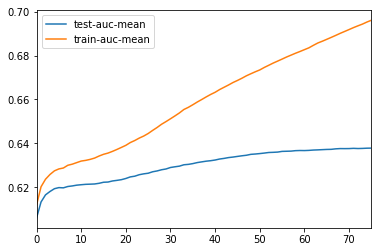

In [9]:
ml.choose_best_n_estimators()

In [12]:
ml.mod

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=76, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=819, silent=True, subsample=1)

In [14]:
ml.mod_fit(ml.mod)

[0]	validation_0-auc:0.613507


[1]	validation_0-auc:0.619251


[2]	validation_0-auc:0.621447


[3]	validation_0-auc:0.624257


[4]	validation_0-auc:0.625745


[5]	validation_0-auc:0.62697


[6]	validation_0-auc:0.626999


[7]	validation_0-auc:0.627388


[8]	validation_0-auc:0.628082


[9]	validation_0-auc:0.628621


[10]	validation_0-auc:0.629355


[11]	validation_0-auc:0.629493


[12]	validation_0-auc:0.630766


[13]	validation_0-auc:0.630761


[14]	validation_0-auc:0.631598


[15]	validation_0-auc:0.632543


[16]	validation_0-auc:0.633711


[17]	validation_0-auc:0.634403


[18]	validation_0-auc:0.63572


[19]	validation_0-auc:0.636289


[20]	validation_0-auc:0.636887


[21]	validation_0-auc:0.637672


[22]	validation_0-auc:0.638308


[23]	validation_0-auc:0.638901


[24]	validation_0-auc:0.639813


[25]	validation_0-auc:0.641382


[26]	validation_0-auc:0.642143


[27]	validation_0-auc:0.643197


[28]	validation_0-auc:0.645224


[29]	validation_0-auc:0.646282


[30]	validation_0-auc:0.64779


[31]	validation_0-auc:0.648595


[32]	validation_0-auc:0.649612


[33]	validation_0-auc:0.650877


[34]	validation_0-auc:0.652214


[35]	validation_0-auc:0.653279


[36]	validation_0-auc:0.654382


[37]	validation_0-auc:0.655199


[38]	validation_0-auc:0.65593


[39]	validation_0-auc:0.656979


[40]	validation_0-auc:0.65738


[41]	validation_0-auc:0.658813


[42]	validation_0-auc:0.659599


[43]	validation_0-auc:0.660373


[44]	validation_0-auc:0.661388


[45]	validation_0-auc:0.662741


[46]	validation_0-auc:0.663594


[47]	validation_0-auc:0.664412


[48]	validation_0-auc:0.665445


[49]	validation_0-auc:0.666171


[50]	validation_0-auc:0.667117


[51]	validation_0-auc:0.668146


[52]	validation_0-auc:0.669177


[53]	validation_0-auc:0.669838


[54]	validation_0-auc:0.670755


[55]	validation_0-auc:0.671302


[56]	validation_0-auc:0.672215


[57]	validation_0-auc:0.672877


[58]	validation_0-auc:0.673687


[59]	validation_0-auc:0.674539


[60]	validation_0-auc:0.675295


[61]	validation_0-auc:0.675972


[62]	validation_0-auc:0.677104


[63]	validation_0-auc:0.677689


[64]	validation_0-auc:0.678415


[65]	validation_0-auc:0.679029


[66]	validation_0-auc:0.679767


[67]	validation_0-auc:0.680629


[68]	validation_0-auc:0.681731


[69]	validation_0-auc:0.68249


[70]	validation_0-auc:0.683413


[71]	validation_0-auc:0.684223


[72]	validation_0-auc:0.684769


[73]	validation_0-auc:0.685033


[74]	validation_0-auc:0.68567


[75]	validation_0-auc:0.686604



Model Report


NameError: global name 'metrics' is not defined